## NYC Property Sales(https://www.kaggle.com/new-york-city/nyc-property-sales) 

With this dataset, I will try to create a model that could predict the sale price of a property based on a given set of parameters.

### Importing all the important libraries and models 

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

### Useful funtions

This function will allow to covert the string categories into limited numerical categories

In [2]:
def AssignCat(col, num_cats):
    if len(col.value_counts().keys()) < num_cats:
        num_cats = len(col.value_counts().keys())
    cats =  pd.DataFrame(col.value_counts().nlargest(num_cats - 1))
    cats['row_num'] = [str(x+1) for x in range(len(cats))]
    cats['name'] = cats.index.values
    col = pd.DataFrame({'val': col.values})
    col = pd.merge(col, cats, how='left', left_on='val', right_on='name')
    col['new'] = col['row_num'].fillna(str(num_cats))
    return col['new'].values;

This function will help us in displaying the scores of the model

In [3]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### Loading and exploring the dataset

In [4]:
dataset=pd.read_csv("../input/nyc-rolling-sales.csv")

Taking a look at the data to determine what fields will be useful in determining the target value i.e. Sale Price

In [5]:
dataset.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [6]:
dataset.shape

(84548, 22)

Lets correct the data type for some of the fields so that we can calculate the co-relation between each of the attributes. This will help us in determining which attributes are important in predicting the sale price.

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
Unnamed: 0                        84548 non-null int64
BOROUGH                           84548 non-null int64
NEIGHBORHOOD                      84548 non-null object
BUILDING CLASS CATEGORY           84548 non-null object
TAX CLASS AT PRESENT              84548 non-null object
BLOCK                             84548 non-null int64
LOT                               84548 non-null int64
EASE-MENT                         84548 non-null object
BUILDING CLASS AT PRESENT         84548 non-null object
ADDRESS                           84548 non-null object
APARTMENT NUMBER                  84548 non-null object
ZIP CODE                          84548 non-null int64
RESIDENTIAL UNITS                 84548 non-null int64
COMMERCIAL UNITS                  84548 non-null int64
TOTAL UNITS                       84548 non-null int64
LAND SQUARE FEET                  84548 non-null object
GRO

In [8]:
dataset["LAND SQUARE FEET"]=pd.to_numeric(dataset["LAND SQUARE FEET"],errors="coerce")
dataset["GROSS SQUARE FEET"]=pd.to_numeric(dataset["GROSS SQUARE FEET"],errors="coerce")
dataset["SALE PRICE"]=pd.to_numeric(dataset["SALE PRICE"],errors="coerce")
dataset['SALE DATE'] = pd.to_datetime(dataset['SALE DATE'], format = '%Y-%m-%d %H:%M:%S')
dataset["SALE YEAR"] = dataset["SALE DATE"].dt.year # Just extracting the sale year to see if it has any strong co-relation
# dataset["AGE"]=dataset["SALE YEAR"]-dataset["YEAR BUILT"] # Adding one more feature just to check if it helps

Lets calculate the co-relation matrix

In [9]:
corr_matrix=dataset.corr()
corr_matrix["SALE PRICE"].sort_values(ascending=False)

SALE PRICE                   1.000000
GROSS SQUARE FEET            0.455423
TOTAL UNITS                  0.125101
RESIDENTIAL UNITS            0.119698
TAX CLASS AT TIME OF SALE    0.091352
LAND SQUARE FEET             0.060183
COMMERCIAL UNITS             0.046006
LOT                          0.012324
SALE YEAR                   -0.002167
YEAR BUILT                  -0.003539
Unnamed: 0                  -0.016296
ZIP CODE                    -0.034170
BLOCK                       -0.061139
BOROUGH                     -0.074418
Name: SALE PRICE, dtype: float64

Based on the above corelation data, I will be dropping some of the columns from the dataset.
  **"Unnamed: 0" and "EASE-MENT"** are empty columns
  **"APARTMENT NUMBER","NEIGHBORHOOD","LOT","ADDRESS"** They have too much randomness in the data. A single instance does not                                                            have enough occurences to be useful for the algorithm.

In [10]:
dataset=dataset.drop(["Unnamed: 0","EASE-MENT","APARTMENT NUMBER","NEIGHBORHOOD","LOT","ADDRESS",],axis=1)

## Lets perform some cleaning on the dataset

### **1. SALE PRICE**

Starting with the Sale Price, lets have a look at the values which are valid and how they are distributed to determine the outliers in the data.

In [11]:
dataset["SALE PRICE"].value_counts()[:5,]

0.0         10228
10.0          766
450000.0      427
550000.0      416
650000.0      414
Name: SALE PRICE, dtype: int64

In [12]:
null_values=84548-sum(dataset["SALE PRICE"].value_counts())
null_values

14561

There are around 24000 invalid values. I will have to drop all of them beacause 
* It is a dependent variable,which I have to predict. So imputing the missing values does not make any sense.
* Given in the description of the dataset, sale price = 0 means, the property was transferred from parent to child

In [13]:
dataset=dataset[dataset["SALE PRICE"].notnull()]
dataset=dataset[dataset["SALE PRICE"]>0]

Before moving on lets look at the frequency distribution of the sale price and later deal with the outlier data

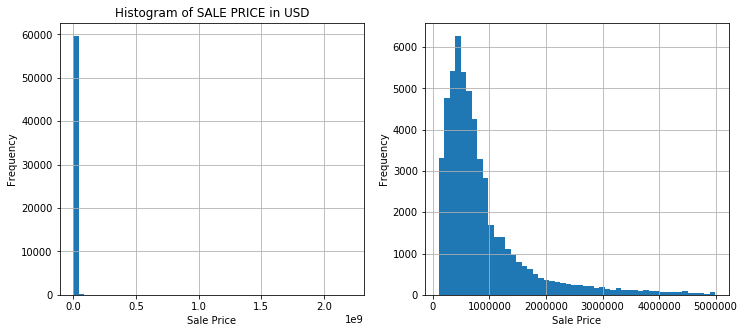

In [14]:
%matplotlib inline
# The first plot shows that most of the sale price is under 50,00,000
plt.subplot(1,2,1)
dataset["SALE PRICE"].hist(bins=50,figsize=(6,5))
plt.title('Histogram of SALE PRICE in USD')
plt.ylabel('Frequency')
plt.xlabel('Sale Price')

# The second plot will show a more detailed view of the prices under 50,00,000
plt.subplot(1,2,2)
dataset1=dataset[(dataset["SALE PRICE"]>100000) & (dataset["SALE PRICE"]<5000000)]
dataset1["SALE PRICE"].hist(bins=50,figsize=(12,5))
plt.ylabel('Frequency')
plt.xlabel('Sale Price')


plt.show()

Lets remove the outlier sale price data

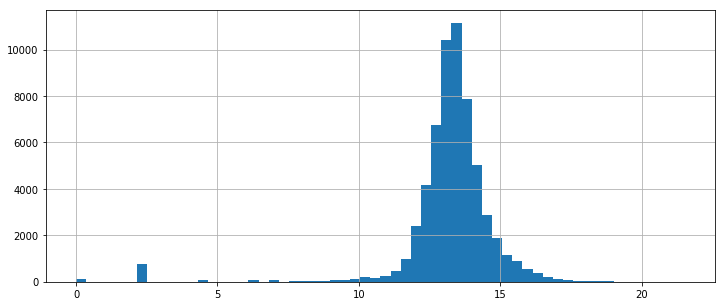

In [15]:
dataset["LOG PRICE"]=dataset["SALE PRICE"].apply(np.log)
dataset["LOG PRICE"].hist(bins=60,figsize=(12,5))
plt.show()

In [16]:
price_mean=dataset["LOG PRICE"].mean()
std_dev=np.std(dataset["LOG PRICE"])
dataset=dataset[dataset["LOG PRICE"] >= (price_mean - std_dev*3)]
dataset=dataset[dataset["LOG PRICE"] <= (price_mean + std_dev*3)]

In [17]:
# We are left with 58548 data instances
dataset.shape

(58548, 18)

### **2. BOROUGH**
    These are some kind of location codes, which are as follows:
         Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5)

In [18]:
#Everything seems to be ok here, no null or 0 values
dataset["BOROUGH"].value_counts()

4    18092
3    15323
1    14271
5     5855
2     5007
Name: BOROUGH, dtype: int64

### **2. BUILDING CLASS CATEGORY**
     Lets take a look at the top 5 categories for this field(Because there are too many).

In [19]:
dataset["BUILDING CLASS CATEGORY"].value_counts()[:5,]

01 ONE FAMILY DWELLINGS                        12690
10 COOPS - ELEVATOR APARTMENTS                 11520
13 CONDOS - ELEVATOR APARTMENTS                10264
02 TWO FAMILY DWELLINGS                         9849
09 COOPS - WALKUP APARTMENTS                    2504
Name: BUILDING CLASS CATEGORY, dtype: int64

The way I will be dealing with this data is that I will take top 4 categories as it is and combine the rest of the categories as one. So in total we will have only 5 categories.

In [20]:
dataset["BCC"]=AssignCat(dataset["BUILDING CLASS CATEGORY"],5) #Sortening the name so it will be easy to access it later
dataset["BCC"].value_counts()

5    14225
1    12690
2    11520
3    10264
4     9849
Name: BCC, dtype: int64

### 3.TAX CLASS AT PRESENT
       I will dealing with this in the same way as BUILDING CLASS CATEGORY but instead of 5, i will be having only 3 categories

In [21]:
dataset["TAX CLASS AT PRESENT"].value_counts()[:5,]

2     25678
1     24915
4      2465
2C     1542
2A     1252
Name: TAX CLASS AT PRESENT, dtype: int64

In [22]:
dataset["TCAP"]=AssignCat(dataset["TAX CLASS AT PRESENT"],3)
dataset["TCAP"].value_counts()

1    25678
2    24915
3     7955
Name: TCAP, dtype: int64

### 4. BLOCK
     No changes here,everything seems to be OK. There are not any invalid values present for this attribute.

In [23]:
sum(dataset["BLOCK"].value_counts())

58548

### 5. BUILDING CLASS AT PRESENT
       I will dealing with this in the same way as BUILDING CLASS CATEGORY.

In [24]:
dataset["BUILDING CLASS AT PRESENT"].value_counts()[:5,]

D4    11311
R4     9776
A1     4729
A5     4071
B2     3199
Name: BUILDING CLASS AT PRESENT, dtype: int64

In [25]:
dataset["BCAP"]=AssignCat(dataset["BUILDING CLASS AT PRESENT"],4)
dataset["BCAP"].value_counts()

4    32732
1    11311
2     9776
3     4729
Name: BCAP, dtype: int64

### 6. RESIDENTIAL UNITS, COMMERCIAL UNITS, TOTAL UNITS

In [26]:
# As we saw earlier that total units is much more strongly co-related to sale price than residential and commercial units. So
# I will fix the Total Units field as there are some irregularities. I will show you one by one. Also I will impute all the 
# missing values later using pipelines.

In [27]:
# First irregularity is that in mone instances the sum of residential units and commercial units is not same
len(dataset[dataset["TOTAL UNITS"]!=dataset["RESIDENTIAL UNITS"]+dataset["COMMERCIAL UNITS"]])

741

In [28]:
dataset["TOTAL UNITS"]=dataset["RESIDENTIAL UNITS"]+dataset["COMMERCIAL UNITS"]
len(dataset[dataset["TOTAL UNITS"]!=dataset["RESIDENTIAL UNITS"]+dataset["COMMERCIAL UNITS"]]) # just a precaution

0

Lets check for any invalid data like total units=0

In [29]:
# Thats a lot of data missing, deleting it won't do any good, so i will impute it later.There are 2 possibilities,either the 
# data was not collected properly or building has not been built yet.
len(dataset[dataset["TOTAL UNITS"]==0])

17232

### 7. LAND SQUARE FEET
       Lets deal with all the unavailable values.

In [30]:
dataset["LAND SQUARE FEET"].value_counts()[:5,]

0.0       8083
2000.0    2382
2500.0    2126
4000.0    1914
1800.0     762
Name: LAND SQUARE FEET, dtype: int64

In [31]:
dataset.shape

(58548, 21)

In [32]:
sum(dataset["LAND SQUARE FEET"].value_counts())  # Seems like around 21000 values are Nan,29000 values are 0(very few valid values)
#                                                   gotta replace them with 0 to impute later

37530

In [33]:
dataset.fillna(value=0,inplace=True)

### 8. GROSS SQUARE FEET
   

In [34]:
dataset["GROSS SQUARE FEET"].value_counts()[:5,]

0.0       30085
1800.0      244
1600.0      235
1440.0      235
2400.0      232
Name: GROSS SQUARE FEET, dtype: int64

In [35]:
sum(dataset["GROSS SQUARE FEET"].value_counts()) # I have already replaced Nan vlaues with 0, so 30,000 values are unavailable
#                                                   this dataset has very large number of missing values, I have a feeling 
#                                                   the algorithms are not going to perform well on this dataset.

58548

### 9. YEAR BUILT
        Lets see how much data available here is valid

In [36]:
len(dataset[dataset["YEAR BUILT"]==0]) #This means that the buildings are not built yet, since there are like only 4000 of them, we can delete these instances

4166

In [37]:
dataset=dataset[dataset["YEAR BUILT"]>0]
len(dataset[dataset["YEAR BUILT"]==0]) # just to check

0

In [38]:
dataset.shape

(54382, 21)

### 10. TAX CLASS AT TIME OF SALE

In [39]:
print(dataset["TAX CLASS AT TIME OF SALE"].value_counts())
print("SUM :",sum(dataset["TAX CLASS AT TIME OF SALE"].value_counts())) # There are no null values prsent here

2    26531
1    25857
4     1994
Name: TAX CLASS AT TIME OF SALE, dtype: int64
SUM : 54382


### 11. BUILDING CLASS AT TIME OF SALE

In [40]:
dataset["BUILDING CLASS AT TIME OF SALE"].value_counts()[:5,]

D4    11313
R4     7965
A1     4727
A5     4057
B2     3192
Name: BUILDING CLASS AT TIME OF SALE, dtype: int64

In [41]:
dataset["BCATOS"]=AssignCat(dataset["BUILDING CLASS AT TIME OF SALE"],4) # Taking the top 3 and combining the rest
dataset["BCATOS"].value_counts()

4    30377
1    11313
2     7965
3     4727
Name: BCATOS, dtype: int64

### 12. SALE DATE
         I extracted Sale Year from this, after which I will use it to calculate the Age of the buildings which could prove 
         to be a much better attribute than SALE DATE

In [42]:
dataset["AGE"]=dataset["SALE YEAR"]-dataset["YEAR BUILT"]

Lets have a last look at all the data features

In [43]:
dataset.shape

(54382, 23)

In [44]:
dataset.describe()

,BOROUGH,BLOCK,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE YEAR,LOG PRICE,AGE
count,54382.000000,54382.000000,54382.000000,54382.000000,54382.000000,54382.000000,5.438200e+04,5.438200e+04,54382.000000,54382.000000,5.438200e+04,54382.000000,54382.000000,54382.000000
mean,2.976500,4230.140046,10823.947593,1.747177,0.161708,1.908885,2.235217e+03,2.209311e+03,1950.857030,1.597863,1.325412e+06,2016.657460,13.405647,65.800430
std,1.326188,3589.874755,645.270074,13.789601,10.139397,17.216402,2.765472e+04,2.131656e+04,34.374559,0.678550,3.928981e+06,0.474563,1.018331,34.374657
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1111.000000,1.000000,2.352000e+03,2016.000000,7.763021,0.000000
25%,2.000000,1330.000000,10303.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1925.000000,1.000000,3.850000e+05,2016.000000,12.860999,46.000000
50%,3.000000,3271.000000,11208.000000,1.000000,0.000000,1.000000,1.476000e+03,9.600000e+02,1949.000000,2.000000,6.300000e+05,2017.000000,13.353475,68.000000
75%,4.000000,6234.000000,11358.000000,2.000000,0.000000,2.000000,2.517000e+03,1.925000e+03,1970.000000,2.000000,1.050000e+06,2017.000000,13.864301,92.000000
max,5.000000,16319.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.228300e+06,3.750565e+06,2017.000000,4.000000,1.260000e+08,2017.000000,18.651792,906.000000


In [45]:
# Based on these features, I will be selecting some of the features for my models
corr_matrix=dataset.corr()
corr_matrix["SALE PRICE"].sort_values(ascending=False)  

SALE PRICE                   1.000000
LOG PRICE                    0.552712
GROSS SQUARE FEET            0.239627
TAX CLASS AT TIME OF SALE    0.223630
RESIDENTIAL UNITS            0.190925
TOTAL UNITS                  0.176649
LAND SQUARE FEET             0.056188
COMMERCIAL UNITS             0.040286
AGE                          0.009354
SALE YEAR                   -0.003166
YEAR BUILT                  -0.009398
ZIP CODE                    -0.131858
BLOCK                       -0.153064
BOROUGH                     -0.190141
Name: SALE PRICE, dtype: float64

In [46]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54382 entries, 0 to 84547
Data columns (total 23 columns):
BOROUGH                           54382 non-null int64
BUILDING CLASS CATEGORY           54382 non-null object
TAX CLASS AT PRESENT              54382 non-null object
BLOCK                             54382 non-null int64
BUILDING CLASS AT PRESENT         54382 non-null object
ZIP CODE                          54382 non-null int64
RESIDENTIAL UNITS                 54382 non-null int64
COMMERCIAL UNITS                  54382 non-null int64
TOTAL UNITS                       54382 non-null int64
LAND SQUARE FEET                  54382 non-null float64
GROSS SQUARE FEET                 54382 non-null float64
YEAR BUILT                        54382 non-null int64
TAX CLASS AT TIME OF SALE         54382 non-null int64
BUILDING CLASS AT TIME OF SALE    54382 non-null object
SALE PRICE                        54382 non-null float64
SALE DATE                         54382 non-null datetim

### Separating the independent and dependent variables

In [47]:
indpt_attribs=["BOROUGH","ZIP CODE","BLOCK","RESIDENTIAL UNITS","TOTAL UNITS","LAND SQUARE FEET","GROSS SQUARE FEET",
               "TAX CLASS AT TIME OF SALE","BCATOS","BCC","TCAP","BCAP","LOG PRICE"]
X=dataset.loc[:,indpt_attribs]
y=dataset.loc[:,"SALE PRICE"]

In [48]:
X.head()

,BOROUGH,ZIP CODE,BLOCK,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BCATOS,BCC,TCAP,BCAP,LOG PRICE
0,1,10009,392,5,5,1633.0,6440.0,2,4,5,3,4,15.706361
3,1,10009,402,10,10,2272.0,6794.0,2,4,5,3,4,15.185745
4,1,10009,404,6,6,2369.0,4615.0,2,4,5,3,4,15.894952
6,1,10009,406,8,8,1750.0,4226.0,2,4,5,3,4,14.976421
9,1,10009,387,24,24,4489.0,18523.0,2,4,5,1,4,16.602495


### Creating the training and test datasets

In [49]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

### This pipeline will help in imputing and scaling the data 
           By doing this, the data will fit better to the model and obviously it will handle only numerical attributes only

In [50]:
num_pipeline=Pipeline([
    ("impute",SimpleImputer(missing_values=0,strategy="median")),
    ("scaler",StandardScaler())
])

### Pre-processing pipeline
    I have created another pipeline which consists of numerical and categorical pipeline. It handles the categorical and
    numerical data and returns a numpy array consisting of all the processed features.

In [51]:
num_attribs=["BLOCK","ZIP CODE","TOTAL UNITS","RESIDENTIAL UNITS","LAND SQUARE FEET","GROSS SQUARE FEET","LOG PRICE"]
cat_attribs=["BOROUGH","BCC","TCAP","BCAP","TAX CLASS AT TIME OF SALE","BCATOS"]

preprocessing_pipeline=ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat",OneHotEncoder(sparse=False,categories="auto"),cat_attribs)
])

### Fitting and transforming training data through pipeline

In [52]:
housing_prepared=preprocessing_pipeline.fit_transform(X_train)

In [53]:
housing_prepared.shape

(43505, 31)

### 1. Linear Regression

In [54]:
lin_reg=LinearRegression()
lin_reg.fit(housing_prepared,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Testing the model on test data and then calculating the mean squared error

In [55]:
X_test_prep1=preprocessing_pipeline.transform(X_test)
lin_reg_predict=lin_reg.predict(X_test_prep1)

In [56]:
# Turns out the mse is too high for this model, lets test out other models
lin_mse=mean_squared_error(lin_reg_predict,y_test)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

3084791.793518974

The model performed very badly on the test data; So before we test the models on test data, we have to tune the model on the train data using cross validation.

In [57]:
lin_mse=cross_val_score(lin_reg,housing_prepared,y_train,
                        scoring="neg_mean_squared_error",cv=10)
lin_rmse=np.sqrt(-lin_mse)

Seems like the model is still underfitting the data,the mse is still the same as it was on test data. We have to use another advanced model.

In [58]:
display_scores(lin_rmse)

Scores: [3212359.23158195 3689743.00576549 3165885.34085627 3484872.01846974
 4916326.03829036 3234108.23043964 3934906.42678008 2278032.4778671
 3027029.98221703 3388183.89449062]
Mean: 3433144.664675828
Standard deviation: 646616.9118414894


### 2. Random Forest Regressor

In [59]:
forest_reg=RandomForestRegressor(n_estimators=10,random_state=42)
forest_reg.fit(housing_prepared,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

The model performed a lot better than linear regression but lets try to do some tuning and see if we can increase the accuracy before we can finalize the model.

In [60]:
forest_reg_mse=cross_val_score(forest_reg,housing_prepared,y_train,cv=10,
                              scoring="neg_mean_squared_error")
forest_reg_rmse=np.sqrt(-forest_reg_mse)
display_scores(forest_reg_rmse)

Scores: [76195.57753984 61500.52576311 74257.15306488 71809.26769801
 60545.12899445 89506.86629392 57081.51664791 14393.89201258
 36649.75800001 94035.59320018]
Mean: 63597.52792148993
Standard deviation: 22673.53923833774


The models' performance seems to be within acceptable range with just error of 41000$ in the sale price. But before choosing this as my final model, lets try to do some tuning and see if we can further reduce the error.

In [61]:
X_test_prep1=preprocessing_pipeline.transform(X_test)
final_predictions=forest_reg.predict(X_test_prep1)

forest_mse=mean_squared_error(y_test,final_predictions)
forest_rmse=np.sqrt(forest_mse)
forest_rmse

41397.99265217469

I will optimize the model using the grid search cv, where I can provide different values for each different parameters and find the best suited for the model. Its kind of hit and trial method.

In [62]:
forest_reg1=RandomForestRegressor(random_state=42)
params=[
      {"n_estimators":[3,5,10,14,30],"max_features":[2,4,6,8]},
    {"bootstrap":[False],"n_estimators":[8,9,11,12],"max_features":[10,11,12,15]}   
]
grid_search_1=GridSearchCV(forest_reg1,params,cv=5,
                        return_train_score=True,scoring="neg_mean_squared_error")

In [63]:
grid_search_1.fit(housing_prepared,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

As we can see that for **n_estimators** the algorithm chose the highest value, so it is possible that it could chose a higher value and provide much better results. But before we do that, lets check the rmse and evaluate the performance of this model on the test set.

In [64]:
grid_search_1.best_params_

{'bootstrap': False, 'max_features': 15, 'n_estimators': 12}

The model seems to perform very poorly on the test set. The reason behind it could be that the model is overfitting the training data very badly. Lets try to use different set of parameters and see if the performance improves.

In [65]:
rfr_model1=grid_search_1.best_estimator_

final_predictions=rfr_model1.predict(X_test_prep1)

rfr_mse=mean_squared_error(y_test,final_predictions)
rfr_rmse=np.sqrt(rfr_mse)
rfr_rmse

233076.2496323758

Trying out the Random forest model with different set of values. I have not shown 2 iterations that I peformed with different set of values because it would have made the code very long.

In [66]:
params=[
      {"bootstrap":[False],"n_estimators":[18,19,20,22,25],"max_features":[20,22,23,24,26]}]  # changing the values for parameters   

grid_search_2=GridSearchCV(forest_reg1,params,cv=5,
                        return_train_score=True,scoring="neg_mean_squared_error")

In [67]:
grid_search_2.fit(housing_prepared,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'bootstrap': [False],
          

In [68]:
grid_search_2.best_params_

{'bootstrap': False, 'max_features': 26, 'n_estimators': 22}

I have tried several other iterations with different parameters but the model performance does not seem to get any better.

In [69]:
rfr_model_2=grid_search_2.best_estimator_

final_predictions=rfr_model_2.predict(X_test_prep1)

rfr_mse=mean_squared_error(y_test,final_predictions)
rfr_rmse=np.sqrt(rfr_mse)
rfr_rmse

79544.91360519669

### This function will help in analyzing if the model is not overfitting or underfitting the data

In [70]:
def plot_learning_curves(model,X,y):
    X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2)
    train_errors,val_errors=[],[]
    for i in range(1,len(X_train)):
        model.fit(X_train[:i],y_train[:i])
        y_train_predict=model.predict(X_train[:i])
        y_val_predict=model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict,y_train[:i]))
        val_errors.append(mean_squared_error(y_val_predict,y_val))
    plt.figure(figsize=(15,10))
    plt.plot(np.sqrt(train_errors),"r-+",linewidth=2,label="Train Error")
    plt.plot(np.sqrt(val_errors),"b-+",linewidth=3,label="Validaton Error")

### Its taking so much time to run all the instances through this plotting function, so i am going to show till 25000 instances only.

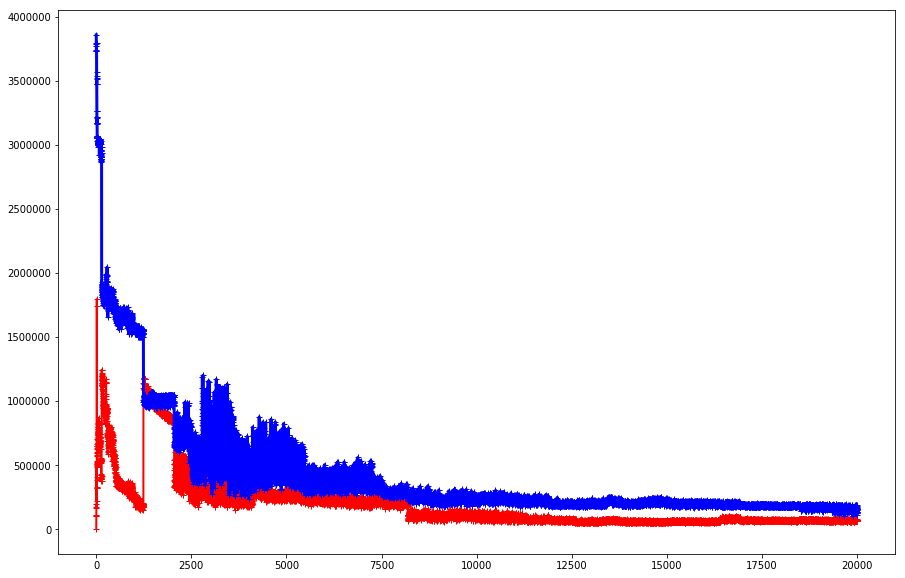

In [71]:
forest_reg1=RandomForestRegressor(n_estimators=10,random_state=42)
plot_learning_curves(forest_reg1,housing_prepared[:25000],y_train[:25000])